# DISPLAY MAPS

## Display sea ice statistics maps in the Weddell Sea using .nc files
- Read netCDF files for the sea ice statistics
- Draw sea ice statistics maps in the Weddell Sea

Credited by Younghyun Koo (kooala317@gmail.com)

## (1) Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import numpy as np
import h5py

import matplotlib.pylab as plt
from math import *
import time
import pandas as pd
import datetime as dt
from tqdm import tqdm
import geopandas
import json
from datetime import datetime, timedelta
from scipy import stats

import pickle

%load_ext autoreload
%autoreload 1
from functions import *

In [56]:
%matplotlib notebook

In [4]:
import ee
import geemap

In [5]:
# Authenticate
ee.Authenticate()

# Initialize with your own project.
ee.Initialize(project = "ee-kooala317")

## (2) Read pickle files

In [67]:
# Define region and lead type
region = "south" # ["south", "west", "entire"]
lead_type = "S" # ["S", "SD", "F001", "F002"]

In [3]:
# 1. How to open "fb_distribution_*.pkl": Freeboard distribution

file_name = f"D:\\Floes\\array\\fb_distribution_{region}_all_v6_{lead_type}.pkl" # put your file name here
open_file = open(file_name, "rb")
[year_all, mth_all, day_all, ITD_bins, ITD_all] = pickle.load(open_file)
open_file.close()
print(ITD_all.shape)

# year_all: year of the data
# mth_all: month of the data
# day_all: day of the data
# ITD_bins: bins of the freeboard distribution
# ITD_all: freeboard counts for the bins of ITD_bins

(40, 1786)


Text(0, 0.5, 'Count')

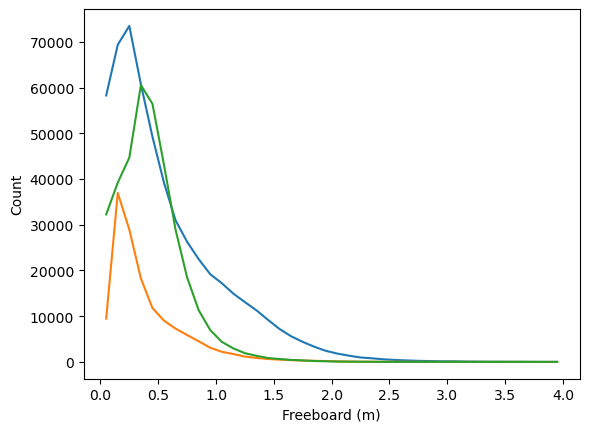

In [84]:
for i in [0, 300, 600]:
    plt.plot(ITD_bins, ITD_all[:, i])
plt.xlabel("Freeboard (m)")
plt.ylabel("Count")

In [68]:
# 2. How to open "floe_profiles_*.pkl": Freeboard profiles (0-50)

file_name = f"D:\\Floes\\array\\floe_profiles_{region}_all_v6_{lead_type}.pkl" # put your file name here
open_file = open(file_name, "rb")
[year_all, mth_all, day_all, floe_profiles, floe_chord_lengths, floe_fb] = pickle.load(open_file)
open_file.close()

print(floe_profiles.shape, floe_profiles.shape)

# year_all: year of the data
# mth_all: month of the data
# day_all: month of the data
# floe_profiles: frofiles of floe freeboard
# floe_chord_lengths: chord length for each floe
# floe_fb: freeboard for each floe

(50, 409269) (50, 409269)


In [64]:
# 3. How to open "fb_chord_full_*.pkl": Chord length & Freeboard for each ice floe

file_name = f"D:\\Floes\\array\\floe_chord_full_{region}_all_v6_{lead_type}.pkl" # put your file name here
with open(file_name, "rb") as open_file:
    [floe_year, floe_month, floe_day, floe_lat, floe_lon, floe_lengths, floe_fb_mean, floe_fb_med, floe_fb_std] = pickle.load(open_file)

print(file_name)
print(floe_lengths.shape, floe_fb_mean.shape, floe_fb_std.shape)

# floe_year: years of individual floes
# floe_month: months of individual floes
# floe_day: days of individual floes
# floe_lat: latitudes of individual floes
# floe_lon: longitudes of individual floes
# floe_lengths: chord lengths of individual floes
# floe_fb_mean: mean freeboards of individual floes
# floe_fb_med: median freeboards of individual floes
# floe_fb_std: standard deviation freeboards of individual floes

D:\Floes\array\floe_chord_full_west_all_v6_S.pkl
(542477,) (542477,) (542477,)


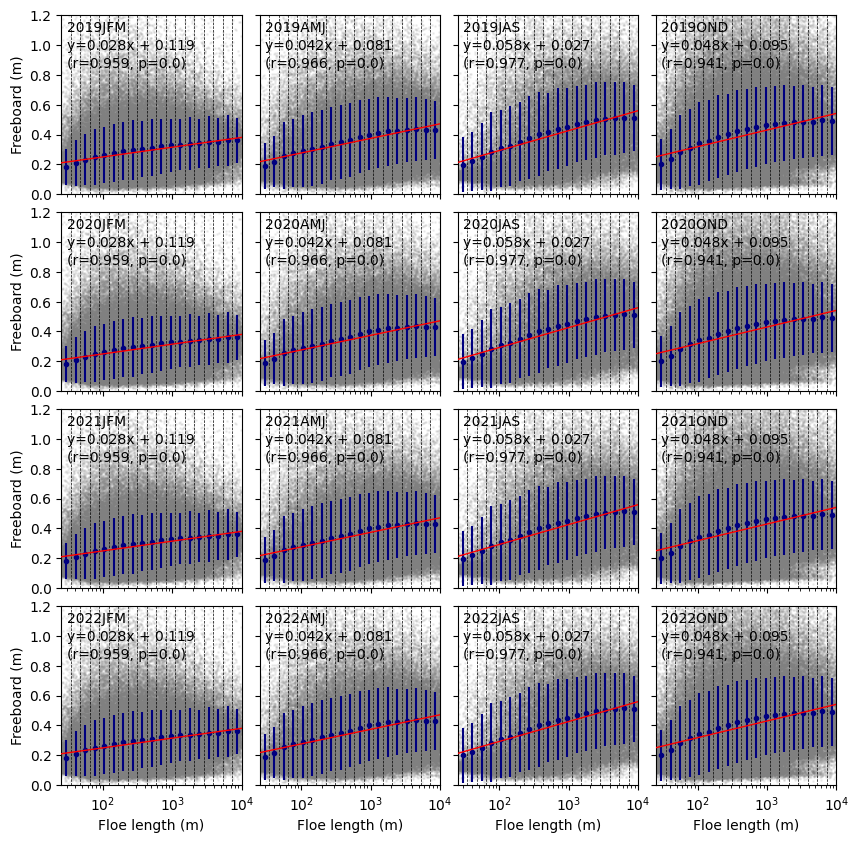

In [12]:
years = range(2019, 2023)
# months = range(7, 13)
months = range(1, 13, 3)

min_size = 25

fig, ax = plt.subplots(len(years), len(months), figsize = (len(months)*2.5, len(years)*2.5), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for n, year in enumerate(years):
    for m, month in enumerate(months):
        
        idx = (floe_month >= month) & (floe_month < month+3) # & (floe_year == year)

        levels = np.logspace(np.log10(min_size), 4, num=20)
        levels_mean = np.zeros(len(levels) - 1)

        ax[n,m].scatter(floe_lengths[idx], floe_fb_med[idx], s = 1, color = "gray", alpha = 0.1)
        for i, l in enumerate(levels):
            if i > 0:
                w = np.where((floe_lengths[idx] >= levels[i-1]) & (floe_lengths[idx] < levels[i]))
                mean = np.mean(floe_fb_med[idx][w])
                # med = np.median(floe_fb_med[idx][w])
                std = np.std(floe_fb_med[idx][w])
                levels_mean[i-1] = np.mean(floe_fb_med[idx][w])
                # plt.errorbar(l, levels_mean[i-1])
                ax[n,m].errorbar((levels[i]+levels[i-1])/2, mean, yerr = std, fmt ='.', color = "navy")
            ax[n,m].axvline(l, ls = "--", c = "k", lw = 0.5)
            
        res = stats.linregress(np.log(levels[1:]), levels_mean)
        b = res.intercept
        a = res.slope
        ax[n,m].plot(levels, np.log(levels)*a + b, color = "red", ls = "-", lw = 1, zorder = 15)
        
        ax[n,m].set_xscale('log')
        if m == 0:
            ax[n,m].set_ylabel('Freeboard (m)')
        if n == len(years)-1:
            ax[n,m].set_xlabel('Floe length (m)')
            
        ax[n,m].set_ylim(0, 1.2)
        ax[n,m].set_xlim(min_size, 1e4)
        m1 = datetime(2019, month, 1).strftime("%b")[:1]
        m2 = datetime(2019, month+1, 1).strftime("%b")[:1]
        m3 = datetime(2019, month+2, 1).strftime("%b")[:1]
        text = f"{int(year)}{m1}{m2}{m3}"
        ax[n,m].annotate(text, xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
        ax[n,m].annotate(f"y={round(a, 3)}x + {round(b,3)}", xy=(0.03, 0.87), xycoords='axes fraction', fontsize=10, ha='left', va='top')
        ax[n,m].annotate(f"(r={round(res.rvalue, 3)}, p={round(res.pvalue, 3)})", xy=(0.03, 0.77), xycoords='axes fraction', fontsize=10, ha='left', va='top')
        # plt.savefig("D:\\Floes\\figures\\FloeLen_Fb_{0}".format(int(year*100+month)), bbox_inches = 'tight')
        
plt.savefig("D:\\Floes\\figures\\FloeLen_Fb_{0}_{1}-{2}".format(region, str(months[0]).zfill(2), str(months[-1]).zfill(2)), bbox_inches = 'tight')
# plt.close()

20it [00:00, 90.39it/s] 
20it [00:00, 183.52it/s]
20it [00:00, 332.62it/s]
20it [00:00, 120.60it/s]


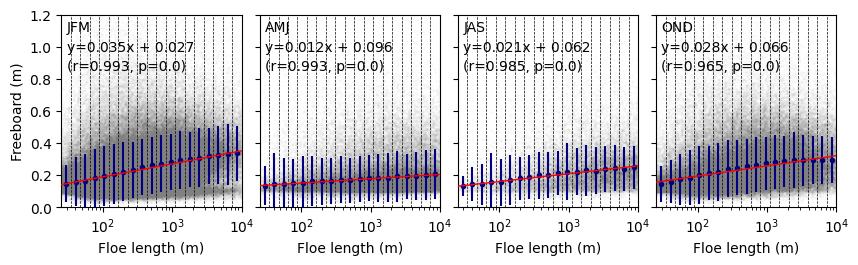

In [75]:
region = "south"

file_name = f"D:\\Floes\\array\\floe_chord_full_{region}_all_v6_{lead_type}.pkl" # put your file name here
with open(file_name, "rb") as open_file:
    [floe_year, floe_month, floe_day, floe_lat, floe_lon, floe_lengths, floe_fb_mean, floe_fb_med, floe_fb_std] = pickle.load(open_file)

# Combine years
years = range(2019, 2023)
# months = range(7, 13)
months = range(1, 13, 3)

year = 0

min_size = 25

fig, ax = plt.subplots(1, len(months), figsize = (len(months)*2.5, 1*2.5), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

n = 1
for m, month in enumerate(months):
    
    idx = (floe_month >= month) & (floe_month < month+3) # & (floe_year == year)

    levels = np.logspace(np.log10(min_size), 4, num=20)
    levels_mean = np.zeros(len(levels) - 1)

    levels2 = np.logspace(np.log10(min_size), 4, num=80)
    fb2 = np.linspace(0, 1.2, num=60)
    xx, yy = np.meshgrid(levels2, fb2)
    density = np.zeros(xx.shape)

    # for i, _ in tqdm(enumerate(levels2[:-1])):
    #     for j, _ in enumerate(fb2[:-1]):
    #         w = np.where((floe_lengths[idx] >= levels2[i]) & (floe_lengths[idx] < levels2[i+1]) & (floe_fb_med[idx] >= fb2[j]) & (floe_fb_med[idx] < fb2[j+1]))[0]
    #         density[j, i] = len(w)

    # den_plot = ax[n,m].pcolormesh(xx, yy, density/np.sum(density)*100, cmap = "Grays", vmax = 0.2, alpha=0.8)

    # if m == 3:
    #     fig.colorbar(den_plot, shrink = 0.8)

    ax[m].scatter(floe_lengths[idx], floe_fb_med[idx], s = 1, color = "gray", alpha = 0.02)
    for i, l in tqdm(enumerate(levels)):
        if i > 0:
            w = np.where((floe_lengths[idx] >= levels[i-1]) & (floe_lengths[idx] < levels[i]))
            mean = np.median(floe_fb_med[idx][w])
            # med = np.median(floe_fb_med[idx][w])
            std = np.std(floe_fb_med[idx][w])
            levels_mean[i-1] = np.median(floe_fb_med[idx][w])
            # plt.errorbar(l, levels_mean[i-1])
            ax[m].errorbar((levels[i]+levels[i-1])/2, mean, yerr = std, fmt ='.', color = "navy")
        ax[m].axvline(l, ls = "--", c = "k", lw = 0.5)    
        
    res = stats.linregress(np.log(levels[1:]), levels_mean)
    b = res.intercept
    a = res.slope
    ax[m].plot(levels, np.log(levels)*a + b, color = "red", ls = "-", lw = 1, zorder = 15)
    
    ax[m].set_xscale('log')
    if m == 0:
        ax[m].set_ylabel('Freeboard (m)')
    
    ax[m].set_xlabel('Floe length (m)')
        
    ax[m].set_ylim(0, 1.2)
    ax[m].set_xlim(min_size, 1e4)
    m1 = datetime(2019, month, 1).strftime("%b")[:1]
    m2 = datetime(2019, month+1, 1).strftime("%b")[:1]
    m3 = datetime(2019, month+2, 1).strftime("%b")[:1]
    text = f"{m1}{m2}{m3}"
    ax[m].annotate(text, xy=(0.03, 0.97), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[m].annotate(f"y={round(a, 3)}x + {round(b,3)}", xy=(0.03, 0.87), xycoords='axes fraction', fontsize=10, ha='left', va='top')
    ax[m].annotate(f"(r={round(res.rvalue, 3)}, p={round(res.pvalue, 3)})", xy=(0.03, 0.77), xycoords='axes fraction', fontsize=10, ha='left', va='top')
        # plt.savefig("D:\\Floes\\figures\\FloeLen_Fb_{0}".format(int(year*100+month)), bbox_inches = 'tight')
        
plt.savefig("D:\\Floes\\figures\\FloeLen_Fb_{0}_allyear_{1}-{2}".format(region, str(months[0]).zfill(2), str(months[-1]).zfill(2)), bbox_inches = 'tight')
# plt.close()

(25, 10000.0)

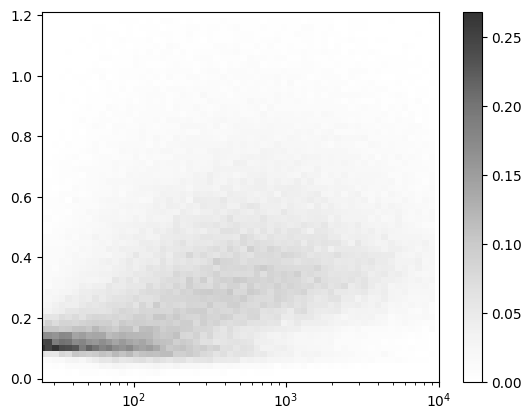

In [58]:
a = plt.pcolormesh(xx, yy, density.transpose()/np.sum(density)*100, cmap = "Grays", alpha=0.8)
fig.colorbar(a)
plt.xscale('log')
plt.xlim(min_size, 1e4)

In [17]:
levels2 = np.logspace(np.log10(min_size), 4, num=100)
fb2 = np.linspace(0, 1.2, num=100)
xx, yy = np.meshgrid(levels2, fb2)

In [29]:
w[0].shape

(3085,)

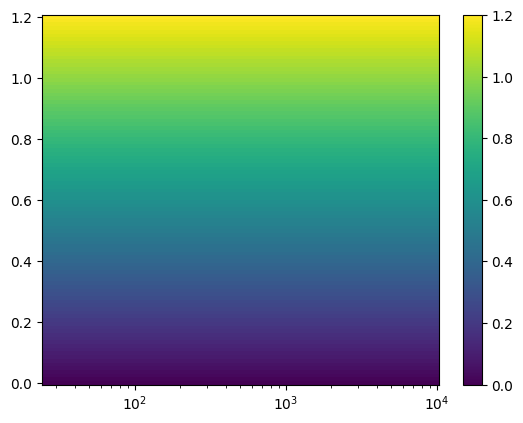

In [22]:
plt.pcolormesh(xx, yy, yy)
plt.colorbar()
plt.xscale('log')

In [574]:
levels = np.logspace(2, 4, num=20)
levels_mean = np.zeros(len(levels) - 1)

In [621]:
years

array([2019, 2020, 2021, 2022])

In [794]:
df = pd.DataFrame()

In [802]:
year = 2020
month = 9

years = np.arange(2019, 2023) #[2022]
months = np.arange(1, 13) #[7, 9, 11]

slopes = np.array([])
pvalues = np.array([])


colors = ["r", "b", "g", "k"]
marks = ["o", "^", "x", "+"]
cnt = 0

for y, year in enumerate(years):
    for m, month in enumerate(months):
        idx = (floe_year == year) & (floe_month == month)

        levels = np.logspace(np.log10(min_size), 4, num=20)
        levels_mean = np.zeros(len(levels) - 1)

        for i in range(1, len(levels)):
            w = np.where((floe_lengths[idx] >= levels[i-1]) & (floe_lengths[idx] < levels[i]))
            levels_mean[i-1] = np.median(floe_fb_med[idx][w])
            
        res = stats.linregress(np.log(levels[1:]), levels_mean)
        b = res.intercept
        a = res.slope
        
        df.loc[cnt, "date"] = datetime(year, month, 15)
        df.loc[cnt, "slope" + region] = a
        df.loc[cnt, "pvalue" + region] = res.pvalue

        if res.pvalue < 0.05:
            pvalues = np.append(pvalues, 1)
        else:
            pvalues = np.append(pvalues, 0)
        cnt += 1
#         plt.scatter(levels[1:], levels_mean, label = year*100+month, color = colors[m], marker = marks[y])
#         plt.plot(levels[1:], a*np.log(levels[1:])+b, label = year*100+month, color = colors[m], ls = "--")
        
# plt.xscale('log')
# plt.legend()

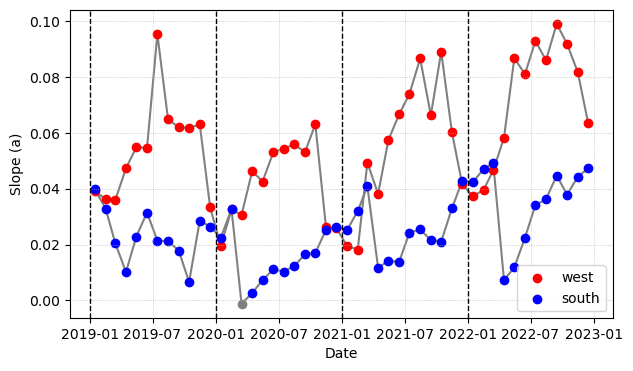

In [805]:
plt.figure(figsize = (7,4))
colors = {'west': 'red', 'south': 'blue'}
for region in ["west", "south"]:
    plt.plot(df["date"], df["slope" + region], zorder = 0, c = "gray")
    plt.scatter(df["date"][df["pvalue" + region] < 0.05], df["slope" + region][df["pvalue" + region] < 0.05], c = colors[region], label = region)
    plt.scatter(df["date"][df["pvalue" + region] > 0.05], df["slope" + region][df["pvalue" + region] > 0.05], c = 'gray')

plt.legend()
plt.grid(ls = ":", lw = 0.5)
plt.xlabel("Date")
plt.ylabel("Slope (a)")
# plt.title(region.upper())
for y in years:
    plt.axvline(datetime(y, 1, 1), color = "k", lw =1, ls = "--")

In [18]:
year = 2019
month = 10

idx = (floe_year == year) & (floe_month == month)
df = pd.DataFrame({'lat': floe_lat[idx], 'lon': floe_lon[idx], 'fb': floe_fb_mean[idx], 'floe_len': floe_lengths[idx], 'day': floe_day[idx]})
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)
uday = np.unique(gdf['day'])
gdf = gdf[gdf['fb'] > 1.0].reset_index(drop = True)


geo_json = gdf.to_json()
 
featureCollection = ee.FeatureCollection(json.loads(geo_json))

In [97]:
plt.scatter(df['lon'], df['lat'], c = df['fb'], vmin = 0.0, vmax = 1.5)
plt.colorbar()

In [34]:
rectangle = ee.Geometry.Rectangle([-60, -66, -55, -65]);
s1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(rectangle)\
.filterDate(f'{year}-{str(month).zfill(2)}-{str(int(uday[0])).zfill(2)}', f'{year}-{str(month).zfill(2)}-28')
image = s1.first();
Map = geemap.Map()
Map.addLayer(image.select(['HH']), {'min': -30, 'max': 0}, 'S1')
Map.addLayer(featureCollection, {'color': 'red'}, 'IS2')
# Map.addLayer(rectangle, {}, 'roi')
Map.centerObject(rectangle, zoom = 8)
Map

Map(center=[-65.51738931207711, -57.50000000000002], controls=(WidgetControl(options=['position', 'transparent…

In [19]:
path = "D:\\Floes\\ATL10\\ATL10-02_{0}*.h5".format(int(year*100+month))
files = [] #glob.glob(path)

for d in uday:
    # path = "D:\\Floes\\ATL10\\ATL10-02_{0}*.h5".format(int(year*10000 + month*100 + d))
    for f in glob.glob("D:\\Floes\\ATL10\\ATL10-02_{0}*.h5".format(int(year*10000 + month*100 + d))):
        files.append(f)

print(len(files), region)

128 entire


In [20]:
if region == "west":
    bbox = [-65, -73, -45, -62]
elif region == "south":
    bbox = [-65, -77.6, -15, -73]
elif region == "entire":
    bbox = [-65, -77.6, -15, -62]

In [21]:
cnt_floes = 0

for k, filename in enumerate(files):

    with h5py.File(filename,'r') as f:
        # print(filename)
        # Check the orbit orientation
        orient = f['orbit_info/sc_orient'][0]
        strong_beams = []

        if orient == 0:
            for i in [1, 2, 3]:
                if f"gt{i}l" in f.keys():
                    strong_beams.append(f"gt{i}l")
        elif orient == 1:
            for i in [1, 2, 3]:
                if f"gt{i}r" in f.keys():
                    strong_beams.append(f"gt{i}r")

        for beam in strong_beams:

            lat = f[beam]['freeboard_segment/latitude'][:]
            lon = f[beam]['freeboard_segment/longitude'][:]
            fb = f[beam]['freeboard_segment/beam_fb_height'][:]

            idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

            lat = lat[idx]
            lon = lon[idx]
            fb = fb[idx]

            seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
            seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
            fb[fb > 100] = np.nan
            stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
            refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
            
            lead_type = "S"

            lead_mask = np.zeros(len(fb))
            if lead_type == "S":  # Specular leads
                lead_mask[(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
            elif lead_type == "SD":  # Specular + dark leads
                lead_mask[(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
            elif lead_type == "F001":  # Freeboard heights (0.01 m)
                lead_mask[fb < 0.01] = 1
            elif lead_type == "F002":  # Freeboard heights (0.02 m)
                lead_mask[fb < 0.02] = 1

            floe_len0, fb_mean0, fb_med0, fb_std0, floe_lat0, floe_lon0, floe_idx0, floe_loc0, lead_width0, lead_pos0, floe_profiles0 = \
            get_floe_length(fb, lead_mask, seg_x, seg_len, lat, lon, 50)

            cnt1 = np.sum(fb_mean0 > 1.0)
            cnt2 = np.sum(fb_mean0 > 2.0)

            if cnt1 > 5 or cnt2 > 0:
                cnt_floes += len(floe_len0)
                print(k, beam, strong_beams.index(beam), " - Info: ", cnt1, cnt2, f"/{len(floe_len0)}", filename)
        
print("DONE!", cnt_floes)

3 gt2r 1  - Info:  14 0 /266 D:\Floes\ATL10\ATL10-02_20191001125932_00710501_006_02.h5
21 gt1r 0  - Info:  15 1 /232 D:\Floes\ATL10\ATL10-02_20191005125113_01320501_006_02.h5
21 gt2r 1  - Info:  33 0 /454 D:\Floes\ATL10\ATL10-02_20191005125113_01320501_006_02.h5
21 gt3r 2  - Info:  10 0 /185 D:\Floes\ATL10\ATL10-02_20191005125113_01320501_006_02.h5
37 gt1r 0  - Info:  3 1 /92 D:\Floes\ATL10\ATL10-02_20191009124252_01930501_006_02.h5
53 gt2r 1  - Info:  13 0 /328 D:\Floes\ATL10\ATL10-02_20191013123433_02540501_006_02.h5
58 gt1r 0  - Info:  13 0 /284 D:\Floes\ATL10\ATL10-02_20191015004312_02770501_006_02.h5
58 gt2r 1  - Info:  22 1 /531 D:\Floes\ATL10\ATL10-02_20191015004312_02770501_006_02.h5
58 gt3r 2  - Info:  14 0 /309 D:\Floes\ATL10\ATL10-02_20191015004312_02770501_006_02.h5
70 gt1r 0  - Info:  17 0 /67 D:\Floes\ATL10\ATL10-02_20191018010032_03230501_006_02.h5
70 gt2r 1  - Info:  29 0 /99 D:\Floes\ATL10\ATL10-02_20191018010032_03230501_006_02.h5
70 gt3r 2  - Info:  35 2 /101 D:\Floe

In [28]:
filename = "D:\\Floes\\ATL10\\" #files[88]
beam_num = 2

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]

    lead_type = "S"

    lead_mask = np.zeros(len(fb))
    if lead_type == "S":  # Specular leads
        lead_mask[(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
    elif lead_type == "SD":  # Specular + dark leads
        lead_mask[(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
    elif lead_type == "F001":  # Freeboard heights (0.01 m)
        lead_mask[fb < 0.01] = 1
    elif lead_type == "F002":  # Freeboard heights (0.02 m)
        lead_mask[fb < 0.02] = 1
        
    floe_len0, fb_mean0, fb_med0, fb_std0, floe_lat0, floe_lon0, floe_idx0, floe_loc0, lead_width0, lead_pos0, floe_profiles0 = \
    get_floe_length(fb, lead_mask, seg_x, seg_len, lat, lon, 50)
    
    # idx = fb_mean0 > 0.5
    df = pd.DataFrame({'lat': floe_lat0, 'lon': floe_lon0, 'fb': fb_mean0, 'floe_len': floe_len0})
    gdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
    )

#     gdf = gdf[gdf['fb'] > 1.0].reset_index(drop = True)

    geo_json = gdf.to_json()

    featureCollection = ee.FeatureCollection(json.loads(geo_json))

# Draw map
rectangle = ee.Geometry.Rectangle([-60, -66, -55, -65]);

d1 = (datetime.strptime(filename[-33:-25], "%Y%m%d") + timedelta(days = 1)).strftime("%Y-%m-%d")
d2 = (datetime.strptime(filename[-33:-25], "%Y%m%d") + timedelta(days = 5)).strftime("%Y-%m-%d")

# point = ee.Geometry.Point([-55.54, -65.38])
# s1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(point).filterDate(d1, d2)
# image = s1.first();
# Map = geemap.Map()
# Map.addLayer(image.select(['HH']), {'min': -30, 'max': 0}, 'S1')
# Map.addLayer(featureCollection, {'color': 'red'}, 'IS2')
# # Map.addLayer(rectangle, {}, 'roi')
# Map.centerObject(featureCollection, zoom = 8)
# Map

D:\Floes\ATL10\ATL10-02_20191203221155_10390501_006_01.h5


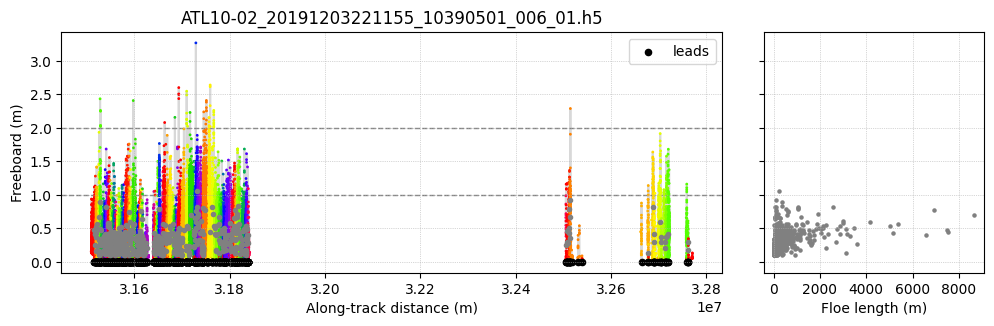

In [14]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,2, figsize = (10, 3), gridspec_kw={'width_ratios': [3, 1]}, sharey = True)
fig.tight_layout()
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
ax[0].scatter(seg_x, fb, c=floe_idx0, s= 1, cmap = "prism")
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet")
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax[0].errorbar(floe_loc0, fb_mean0, xerr = floe_len0/2, fmt ='.', color = "gray")
ax[0].scatter(lead_pos0, lead_pos0*0, c= "k", s= 20, label = "leads")
ax[0].legend()
ax[0].axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax[0].axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_xlabel("Along-track distance (m)")
ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32705*1000, 32720*1000);
# ax[0].set_xlim(27588*1000, 27600*1000);

ax[1].scatter(floe_len0, fb_mean0, s = 5, c = "gray")
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Floe length (m)")
# ax[1].set_xscale('log')

plt.show()
# plt.close()

D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


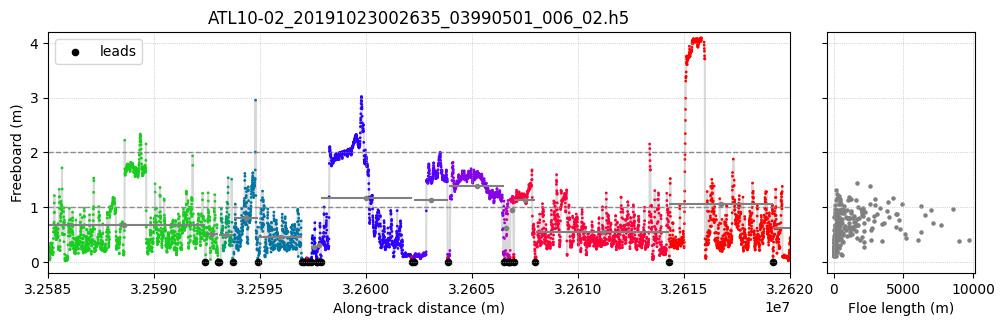

In [29]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,2, figsize = (10, 3), gridspec_kw={'width_ratios': [5, 1]}, sharey = True)
fig.tight_layout()
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
ax[0].scatter(seg_x, fb, c=floe_idx0, s= 1, cmap = "prism")
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet")
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax[0].errorbar(floe_loc0, fb_mean0, xerr = floe_len0/2, fmt ='.', color = "gray")
ax[0].scatter(lead_pos0, lead_pos0*0, c= "k", s= 20, label = "leads")
ax[0].legend()
ax[0].axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax[0].axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_xlabel("Along-track distance (m)")
ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32790*1000, 32825*1000);
ax[0].set_xlim(32585*1000, 32620*1000);
ax[0].set_ylim(-0.2, 4.2);

ax[1].scatter(floe_len0, fb_mean0, s = 5, c = "gray")
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Floe length (m)")
# ax[1].set_xscale('log')

plt.show()
# plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


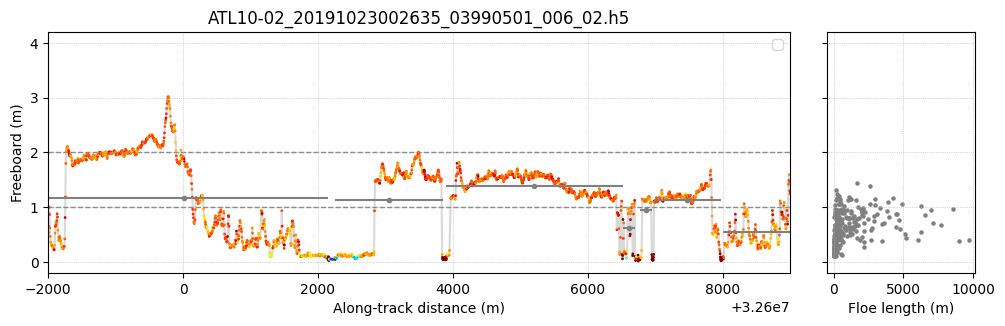

In [41]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,2, figsize = (10, 3), gridspec_kw={'width_ratios': [5, 1]}, sharey = True)
fig.tight_layout()
ax[0].plot(seg_x, fb, c="gray", zorder=1, alpha = 0.3)
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
ax[0].scatter(seg_x, fb, c=ph_rate, s= 1, cmap = "jet", vmax = 10) # photon rate
# ax[0].scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet")
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax[0].errorbar(floe_loc0, fb_mean0, xerr = floe_len0/2, fmt ='.', color = "gray")
# ax[0].scatter(lead_pos0, lead_pos0*0, c= "k", s= 20, label = "leads")
ax[0].legend()
ax[0].axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax[0].axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

ax[0].set_title(os.path.basename(filename))
ax[0].grid(ls = ":", lw = 0.5)
ax[0].set_xlabel("Along-track distance (m)")
ax[0].set_ylabel("Freeboard (m)");

# ax[0].set_xlim(32790*1000, 32825*1000);
ax[0].set_xlim(32598*1000, 32609*1000);
ax[0].set_ylim(-0.2, 4.2);

ax[1].scatter(floe_len0, fb_mean0, s = 5, c = "gray")
ax[1].grid(ls = ":", lw = 0.5)
ax[1].set_xlabel("Floe length (m)")
# ax[1].set_xscale('log')

plt.show()
# plt.close()

## Draw profiles for figure

In [4]:
bbox = [-65, -77.6, -15, -62]

In [46]:
filename = "D:\\Floes\\ATL10\\ATL10-02_20190309223003_10920201_006_02.h5" #files[88]
filename = "D:\\Floes\\ATL10\\ATL10-02_20190906141506_10770401_006_02.h5" #files[88]
filename = "D:\\Floes\\ATL10\\ATL10-02_20191023002635_03990501_006_02.h5"

beam_num = 2

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams[beam_num:beam_num+1]:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        ph_rate = f[beam]['freeboard_segment/heights/photon_rate'][idx]
        sigma = f[beam]['freeboard_segment/heights/height_segment_sigma'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]

    lead_type = "S"

    lead_mask = np.zeros(len(fb))
    if lead_type == "S":  # Specular leads
        lead_mask[(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
    elif lead_type == "SD":  # Specular + dark leads
        lead_mask[(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
    elif lead_type == "F001":  # Freeboard heights (0.01 m)
        lead_mask[fb < 0.01] = 1
    elif lead_type == "F002":  # Freeboard heights (0.02 m)
        lead_mask[fb < 0.02] = 1
        
    floe_len0, fb_mean0, fb_med0, fb_std0, floe_lat0, floe_lon0, floe_idx0, floe_loc0, lead_width0, lead_pos0, floe_profiles0 = \
    get_floe_length(fb, lead_mask, seg_x, seg_len, lat, lon, 50)
    
    # idx = fb_mean0 > 0.5
    df = pd.DataFrame({'lat': floe_lat0, 'lon': floe_lon0, 'fb': fb_mean0, 'floe_len': floe_len0})
    gdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
    )

#     gdf = gdf[gdf['fb'] > 1.0].reset_index(drop = True)

    geo_json = gdf.to_json()

d1 = (datetime.strptime(filename[-33:-25], "%Y%m%d") + timedelta(days = 1)).strftime("%Y-%m-%d")
d2 = (datetime.strptime(filename[-33:-25], "%Y%m%d") + timedelta(days = 5)).strftime("%Y-%m-%d")


D:\Floes\ATL10\ATL10-02_20191023002635_03990501_006_02.h5


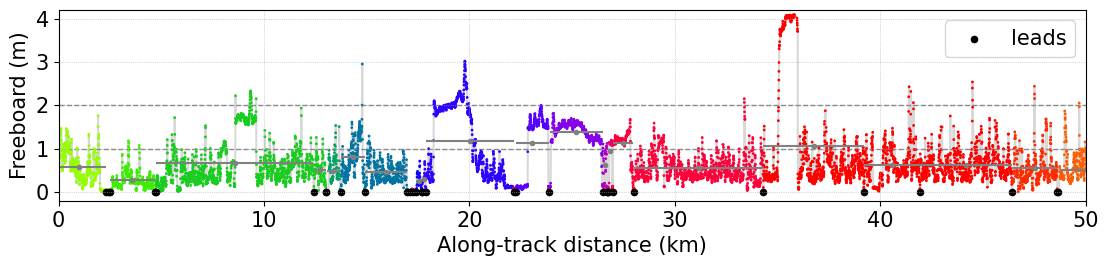

In [48]:
%matplotlib inline
print(filename)
fig, ax = plt.subplots(1,1, figsize = (11, 2.5), dpi=100)
fig.tight_layout()


# x1, x2 = [27555*1000, 27605*1000];
x1, x2 = [32580*1000, 32630*1000];

ax.plot((seg_x-x1)/1000, fb, c="gray", zorder=1, alpha = 0.3)
ax.scatter((seg_x-x1)/1000, fb, c=floe_idx0, s= 1, cmap = "prism")
# ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet")
# plt.scatter(floe_loc0, fb_mean0, s = 1, c = "k")
ax.errorbar((floe_loc0-x1)/1000, fb_mean0, xerr = floe_len0/2000, fmt ='.', color = "gray")
ax.scatter((lead_pos0-x1)/1000, lead_pos0*0, c= "k", s= 20, label = "leads")
ax.legend(fontsize = 15)
ax.axhline(1, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)
ax.axhline(2, ls = "--", lw = 1, c="k", zorder=0, alpha = 0.5)

# ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)
ax.set_xlabel("Along-track distance (km)", fontsize = 15)
ax.set_ylabel("Freeboard (m)", fontsize = 15);

# ax[0].set_xlim(32790*1000, 32825*1000);

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlim(0, x2/1000-x1/1000);
ax.set_ylim(-0.2, 4.2);

# plt.show()
figname = os.path.basename(filename).replace(".h5", f"_{beam_num}.png")
plt.savefig(f"D:\\Floes\\figures\\profiles_{figname}", bbox_inches = "tight")
# plt.close()

In [21]:
filename.replace(".h5", f"_{beam_num}.png")

'D:\\Floes\\ATL10\\ATL10-02_20190309223003_10920201_006_02_0.png'

In [190]:
# Function to calculate sea ice floe length
def get_floe_length(freeboard, lead_mask, seg_dist, seg_len, lat, lon, nprof = 50):
    # INPUT:
    # freeboard: along-track freeboard measurement of ICESat-2 ATL10 track
    # lead_mask: along-track lead detection result (0: lead; 1: non-lead)
    # seg_dist: along-track distance of ICESat-2 ATL10 track (unit: meters)
    # nprof: number of points in normalized profiles
    
    delta_dist = np.append(0, np.diff(seg_dist))
    
    # Floe parameters
    floe_length = np.array([]) # Floe length (unit: m)    
    floe_fb_mean = np.array([]) # Floe freeboard (unit: m) 
    floe_fb_median = np.array([]) # Floe freeboard (unit: m) 
    floe_fb_std = np.array([]) # Floe freeboard (unit: m)
    floe_lat = np.array([]) # Floe latitude
    floe_lon = np.array([]) # Floe longitude
    floe_loc = np.array([]) # Floe longitude
    
    floe_idx = np.zeros(freeboard.shape) - 1
    floe_cnt = 0
    
    # Lead parameters
    lead_length = np.array([]) # Lead length (unit: m)
    lead_position = np.array([]) # Lead position (unit: m along the track)
    lead_fb = np.array([]) # Lead freeboard (unit: m)
    
    # Floe profile parameter
    rprof = np.linspace(0,1,nprof)
    floe_profiles = []
    
    # Floe starting index
    ice_cnt_st = 0
    # Floe ending index
    ice_cnt_en = 0
    
    # Lead starting index
    lead_cnt_st = 0
    # Lead ending index
    lead_cnt_en = 0    
    
    for i in range(1, len(freeboard)):
        # Remove invalid floe boundary:
        # If two ATL10 points are separated farther than 4 x (their segment length),
        # these two points are considered invalid
        # (because we cannot confirm the real sea ice condition (lead occurence, etc.) between them)
        if delta_dist[i] > 4*(seg_len[i] + seg_len[i-1]):
            freeboard[i] = np.nan
            freeboard[i-1] = np.nan
        
        if (lead_mask[i] == 0) and (lead_mask[i-1] == 1): # start floe & stop lead
            # Initialize floe
            ice_cnt_st = i
            ice_cnt_en = i
            
            # Complete lead
            lead_length = np.append(lead_length, abs(seg_dist[lead_cnt_en] - seg_dist[lead_cnt_st]) + 0.5*seg_len[lead_cnt_st] + 0.5*seg_len[lead_cnt_en])
            # lead_length = np.append(lead_length, np.sum(seg_len[lead_cnt_st:lead_cnt_en+1]))
            lead_fb = np.append(lead_fb, np.mean(freeboard[lead_cnt_st:lead_cnt_en+1]))
            lead_position = np.append(lead_position, (seg_dist[lead_cnt_en] + seg_dist[lead_cnt_st])/2)
                                    
        elif (lead_mask[i] == 0) and (lead_mask[i-1] == 0): # grow floe
            ice_cnt_en += 1
            
        elif (lead_mask[i] == 1) and (lead_mask[i-1] == 1): # grow lead
            lead_cnt_en += 1
            
        elif (lead_mask[i] == 1) and (lead_mask[i-1] == 0): # stop floe & start lead
            # Complete floe
            floe_length = np.append(floe_length, abs(seg_dist[ice_cnt_en] - seg_dist[ice_cnt_st]) + 0.5*seg_len[ice_cnt_st] + 0.5*seg_len[ice_cnt_en])
            # floe_length = np.append(floe_length, np.sum(seg_len[ice_cnt_st:ice_cnt_en+1]))
            floe_fb_mean = np.append(floe_fb_mean, np.mean(freeboard[ice_cnt_st:ice_cnt_en+1]))
            floe_fb_median = np.append(floe_fb_median, np.median(freeboard[ice_cnt_st:ice_cnt_en+1]))
            floe_fb_std = np.append(floe_fb_std, np.std(freeboard[ice_cnt_st:ice_cnt_en+1]))
            floe_lat = np.append(floe_lat, np.mean(lat[ice_cnt_st:ice_cnt_en+1]))
            floe_lon = np.append(floe_lon, np.mean(lon[ice_cnt_st:ice_cnt_en+1]))
            floe_loc = np.append(floe_loc, (seg_dist[ice_cnt_st] + seg_dist[ice_cnt_en+1])/2)
            
            floe_cnt += 1
            floe_idx[ice_cnt_st:ice_cnt_en+1] = floe_cnt
            
            prof = freeboard[ice_cnt_st:ice_cnt_en+1]
            xx_prof = np.linspace(0,1,ice_cnt_en-ice_cnt_st+1)
            prof2 = np.interp(rprof, xx_prof, prof)
            floe_profiles.append(np.interp(rprof, xx_prof, prof))
            # floe_idx += 1
            
            # Initialize lead
            lead_cnt_st = i
            lead_cnt_en = i
        
    # Removing spurious floes (< 50m, > 10 km, fb < 0.1)
    
    # print(floe_length.shape, len(floe_profiles))
    idx = np.where((floe_length >= 10) & (floe_length <= 10000) & (floe_fb_mean >= 0.1))[0]  
    floe_fb_mean = floe_fb_mean[idx] #np.delete(floe_fb_mean, remove_idx)
    floe_fb_median = floe_fb_median[idx] #np.delete(floe_fb_median, remove_idx)
    floe_fb_std = floe_fb_std[idx] #np.delete(floe_fb_std, remove_idx)
    floe_length = floe_length[idx] #np.delete(floe_length, remove_idx)
    floe_lat = floe_lat[idx]
    floe_lon = floe_lon[idx]
    floe_loc = floe_loc[idx]
    if len(floe_profiles) > 0:
        floe_profiles = np.array(floe_profiles)[idx, :].transpose() #np.array(floe_profiles)[~remove_idx, :].transpose()
    else:
        floe_profiles = np.array(floe_profiles)
    # print(floe_length.shape, floe_profiles.shape)
    
    # Removing spurious leads
    idx = np.where((lead_length >= 10) | (lead_fb <= 0.1))[0]
    lead_length = lead_length[idx] #np.delete(lead_length, remove_idx)    
    lead_position = lead_position[idx] #np.delete(lead_position, remove_idx)

    return floe_length, floe_fb_mean, floe_fb_median, floe_fb_std, floe_lat, floe_lon, floe_idx, floe_loc, lead_length, lead_position, floe_profiles

(32700.0, 32760.0)

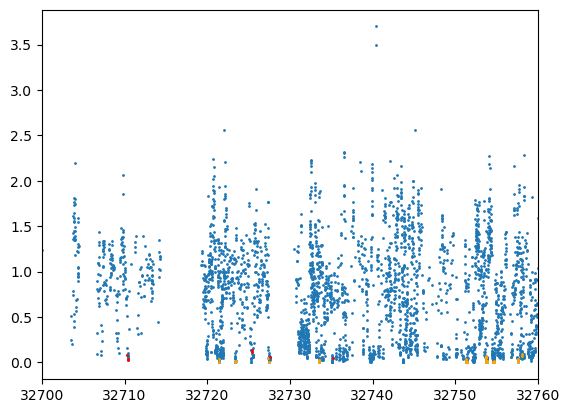

In [135]:
plt.scatter(seg_x, fb, s= 1)
plt.scatter(seg_x[lead == 1], fb[lead == 1], c='orange', s=1)
plt.scatter(seg_x[lead == 2], fb[lead == 2], c='r', s=1)
# plt.xlim(-66.3, -66.2)
plt.xlim(32700, 32760)

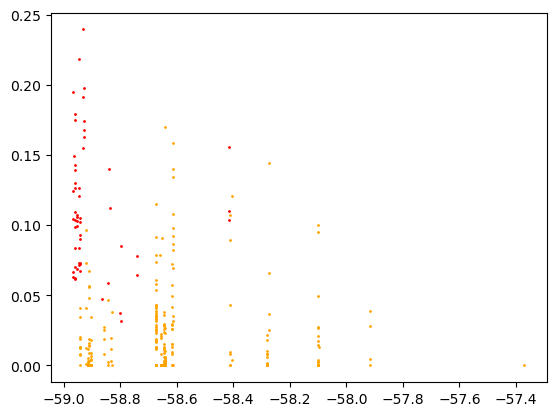

In [97]:
plt.scatter(lon[lead == 1], fb[lead == 1], c='orange', s=1)
plt.scatter(lon[lead == 2], fb[lead == 2], c='r', s=1)


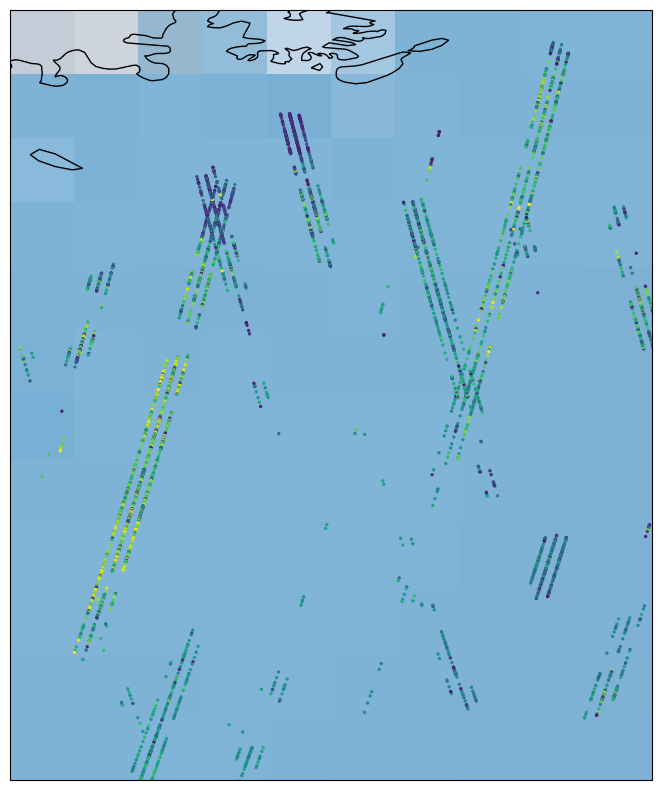

In [228]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10,10))

ax=fig.add_subplot(projection=ccrs.PlateCarree())

# gl = ax.gridlines(
#     draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
#     xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
# )

ax.coastlines()
ax.scatter(floe_lon[idx], floe_lat[idx], c = floe_fb_mean[idx], vmin = 0.0, vmax = 1.2, s = 2)
# ax.scatter(floe_lon[idx], floe_lat[idx], c = floe_lengths[idx], s = 2)
ax.set_xlim(-60, -55)
ax.stock_img()
ax.set_ylim(-70, -64)
# plt.savefig(f'/g/data/gv90/P6_data/report_card/report_card_{year}{month}.png',bbox_inches='tight')
plt.show()

#### Derive FSD (floe size distribution) from `fb_chord_full*.pkl`

In [79]:
floe_chord_bins = np.arange(0, 10000, 50) #np.arange(0.1, 1.5, num=50)
floe_chord_bins_mean = 0.5*(floe_chord_bins[0:-1] + floe_chord_bins[1:])

for region in ["south", "west", "entire"]:
    for lead_type in ["SD", "S", "F001", "F002"]:
        print(region, lead_type)
        file_name = f"D:\\Floes\\array\\floe_chord_full_{region}_all_v6_{lead_type}.pkl" # put your file name here
        open_file = open(file_name, "rb")
        [floe_year, floe_month, floe_day, floe_lat, floe_lon, floe_lengths, floe_fb_mean, floe_fb_med, floe_fb_std] = pickle.load(open_file)
        open_file.close()

        floe_dates = np.zeros(floe_year.shape)
        for i in range(0, len(floe_dates)):
            floe_dates[i] = floe_year[i]*10000 + floe_month[i]*100 + floe_day[i]
        unique_dates = np.unique(floe_dates)

        FSD = np.zeros([len(floe_chord_bins_mean), len(unique_dates)])

        years = np.zeros(len(unique_dates))
        months = np.zeros(len(unique_dates))
        days = np.zeros(len(unique_dates))
        floe_len_all = []

        for i in tqdm(range(0, len(unique_dates))):
            idx = np.where(floe_dates == unique_dates[i])[0]
            floe_len = floe_lengths[idx]
            floe_len_all.append(floe_len)
            FSD[:, i], _ = np.histogram(floe_len, bins=floe_chord_bins)
            years[i] = floe_year[idx[0]]
            months[i] = floe_month[idx[0]]
            days[i] = floe_day[idx[0]]

        with open(f"D:\\Floes\\array\\FSD_{region}_all_v6_{lead_type}.pkl", 'wb') as file:
            pickle.dump([years, months, days, FSD, floe_chord_bins_mean, floe_len_all], file)

south SD


100%|██████████████████████████████████████████████████████████████████████| 1464/1464 [00:00<00:00, 1989.10it/s]


south S


100%|██████████████████████████████████████████████████████████████████████| 1423/1423 [00:00<00:00, 2111.31it/s]


south F001


100%|██████████████████████████████████████████████████████████████████████| 1443/1443 [00:00<00:00, 3244.20it/s]


south F002


100%|██████████████████████████████████████████████████████████████████████| 1453/1453 [00:00<00:00, 2328.36it/s]


west SD


100%|██████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 1878.76it/s]


west S


100%|██████████████████████████████████████████████████████████████████████| 1143/1143 [00:00<00:00, 2229.41it/s]


west F001


100%|██████████████████████████████████████████████████████████████████████| 1158/1158 [00:00<00:00, 3098.91it/s]


west F002


100%|██████████████████████████████████████████████████████████████████████| 1160/1160 [00:00<00:00, 2962.74it/s]


entire SD


100%|███████████████████████████████████████████████████████████████████████| 1575/1575 [00:04<00:00, 341.20it/s]


entire S


100%|███████████████████████████████████████████████████████████████████████| 1571/1571 [00:02<00:00, 606.04it/s]


entire F001


100%|███████████████████████████████████████████████████████████████████████| 1571/1571 [00:02<00:00, 612.39it/s]


entire F002


100%|███████████████████████████████████████████████████████████████████████| 1571/1571 [00:02<00:00, 549.89it/s]
